# Basketball-Reference Scraper Overview
The following code will walk you through how to scrape NBA player and game data from www.basketball-reference.com and input it into a Pandas database. In other scripts within this directory, we will be using the data captured here to run analyses that will help the average user ask both broad and specific questions related to the NBA. We will probe on what statistics and criteria are important for an NBA team to win an NBA championship, how the league has evolved year-over-year, touch on the GOAT debate, and ultimately, build algorithms that can (hopefully) help us all beat Vegas lines consistently so that we can all retire from our day jobs and gamble on the NBA for the rest of our careers. 

None of this could have been done without the tireless and comprehensive effort of those who work at [Basketball Reference](http://www.basketball-reference.com) providing an open-source, API-friendly database containing millions of datapoints from which the entirety of this codebase is built. 

For any questions/concerns, feel free to reach out to me directly at rahim.hashim@columbia.edu. And in the case that this is useful to anyone for future projects, please give credit where credit is due, both to [Basketball Reference](http://www.basketball-reference.com) and myself. Enjoy!

***
## The Basics
__Jupyter Notebook__: All of the following code is hosted in a Python 3 Jupyter Notebook. It is recommended to use Anaconda to access the Notebook in order to have synchronously have access to all Python Libraries used in the rest of the code. 

In order to execute and compile code in the notebook, go to the desired code box and press _Shift_ + _Enter_ at the same time. All code below is recommended to be executed from top to bottom in order.

__Python Libraries__: Python is a beautiful language for a number of reasons, one of which is it's immense
amount of pre-built libraries that do much of the heavy lifting in any web-scraping /
data analysis project. When getting familiar with Python and starting a new project, be
sure to look through the internet for a Python library that may help. A comprehensive list
that I often refer to before starting a project is here: [https://github.com/vinta/awesome-python](https://github.com/vinta/awesome-python)

__Installing Libraries__: In case you receive an error upon trying to execute the following box, such as _ModuleNotFoundError: No module named 'numpy'_, go back to your terminal and open a new tab, and install the library using pip: _pip install numpy_

In [1]:
import re
import os
import sys
import requests
import datetime
import time
import threading
import numpy as np
from timeit import timeit
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from string import ascii_lowercase

#(Non-Python Library)
#stateDict is a Dictionary that I created to help with geography-based analyses
from Regions import stateDict

***
## Class Instantiation
Another reason why Python is awesome is it's easy-to-use object-oriented programming. 
In case you aren't familiar with object oriented programming - _Classes_ and 
_Objects_ are the two main aspects of object oriented programming. A class creates a 
new unique and malleable type (e.g. int, string, list) with user-designated attributes. Objects are simply instances of the class. 

Here, the __Player__ class, __BasicStats__ class, __AdvancedStats__ class, __ShootingStats__ class, and __PlayByPlayStats__ class are initiated (from playerStatObjects), with defined attributes (e.g. name, draftYear...).
Once we scrape www.basketball-reference.com, we will create type-specific objects that will each have the following attributes. 

In [2]:
from PlayerStatObjects import Player, BasicStats, AdvancedStats, ShootingStats, PlayByPlayStats

***
## Scraping All NBA Players and Meta-Info

playerScraper and metaDataScraper will be doing most of the work to scrape data on each player's background and physical attributes.<br>
> Example Overview Source (last name starting with a): https://www.basketball-reference.com/players/a/<br>
> Example meta-data (Karim Abdul-Jabbar): https://www.basketball-reference.com/players/a/abdulka01.html<br>
> For documentation on requests(): https://realpython.com/python-requests/<br>
> For documentation on BeautifulSoup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

___Time Estimates:___ This is the most computationally-intensive function in the program, requiring many url requests in order to complete.<br>
>*Without threading:* ~1hr<br>
>*With threading:* ~15min<br>

In [3]:
import importlib
from collections import defaultdict
from metaScraper import metaInfoScraper
#importlib.reload(metaScraper)

playersHash = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
def playerTableScraper(url, playerHash):
    #Running playerScraper to capture Player Overview data on each player
    playerHash = metaScraper.metaInfoScraper(url, playerHash)

urls = []
for letter in ascii_lowercase:
    url = 'https://www.basketball-reference.com/players/' + letter
    urls.append(url)

start_datetime = datetime.datetime.now()
start_time = time.time()
print ('metaInfoScraper')
print ('   Start Time:', str(start_datetime.time())[:11])

'''
## Thread flag decides whether you want to use parallel processing or standard
'''
thread_flag = True

# Sequential-Processing
if thread_flag == False:
    print('    threading inactivated')
    for url in urls:
        playersHash = metaInfoScraper(url, playersHash)
# Parallel-Processing
else:
    print('    threading activated')
    threads = []
    for url in urls:
        thread = threading.Thread(target=metaInfoScraper, args=(url,playersHash,))
        threads += [thread]
        thread.start()
    for thread in threads:
        thread.join() # makes sure that the main program waits until all threads have terminated
end_time = time.time()
print ('   Run Time:', str((end_time - start_time)/60)[:6], 'min')

metaInfoScraper
   Start Time: 11:57:25.66
    threading activated
      'x' Players Captured:  0
      'q' Players Captured:  5
      'u' Players Captured:  11
      'z' Players Captured:  20
      'y' Players Captured:  19
      'i' Players Captured:  26
      'v' Players Captured:  58
      'o' Players Captured:  90
      'n' Players Captured:  102
      'e' Players Captured:  104
      'f' Players Captured:  144
      'k' Players Captured:  169
      'a' Players Captured:  166
      't' Players Captured:  187
      'l' Players Captured:  191
      'p' Players Captured:  212
      'g' Players Captured:  243
      'd' Players Captured:  238
      'r' Players Captured:  249
      'j' Players Captured:  235
      'c' Players Captured:  297
      'h' Players Captured:  342
      'w' Players Captured:  368
      's' Players Captured:  414
      'm' Players Captured:  451
      'b' Players Captured:  459
   Run Time: 20.378 min


***
## Data Organization
To help us understand how all the data is organized, here's a visual:

In [4]:
print(playersHash['Kareem Abdul-Jabbar']['stats']['regular_season'].keys())

dict_keys(['per_game', 'total', 'per_36', 'per_100', 'advanced', 'shooting', 'play-by-play'])


***
## Meta-Data Analysis
Now that we've scraped all the meta-info on each player, we can start running analyses.

Below, a few simple analyses are included to help you get started. The first set of graphs examine height distribution (left), weight distribution (middle), and shooting handedness (right).

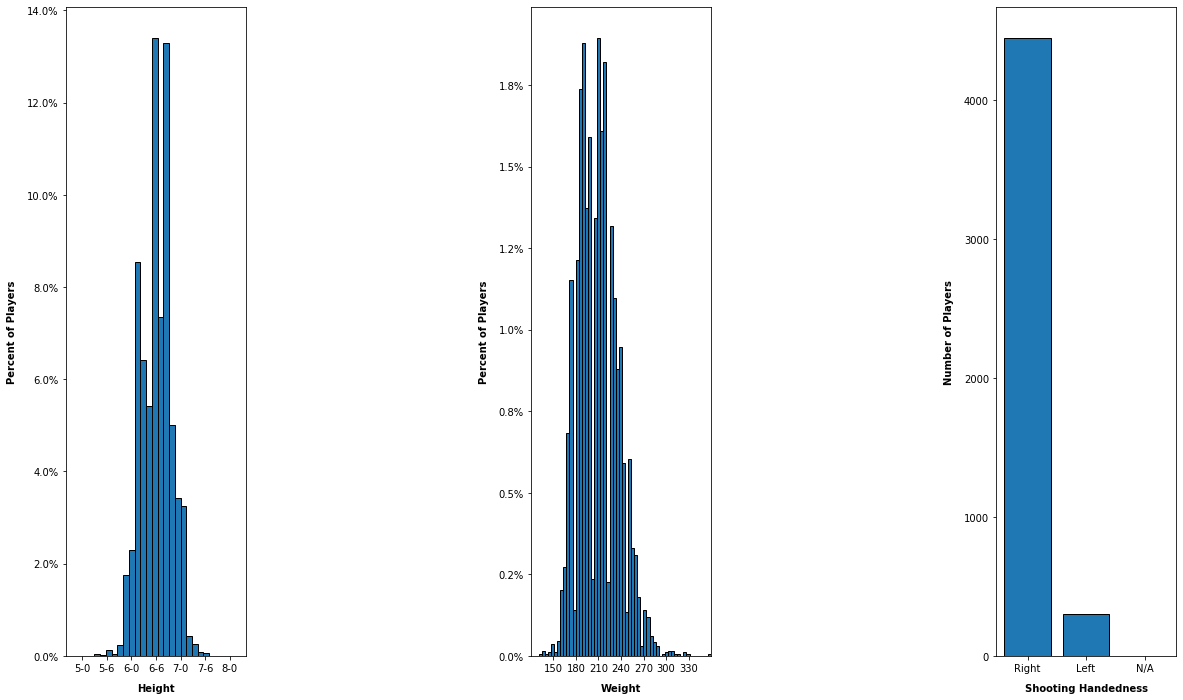

In [5]:
def metaPlot():
    height_list = []; weight_list = []
    rightCount = 0; leftCount = 0; noHandCount = 0
    for player in playersHash.keys():
        try:
            height_list.append(int(playersHash[player]['meta_info'].height))
        except:
            pass
        try:
            weight_list.append(int(playersHash[player]['meta_info'].weight))
        except:
            pass
        if playersHash[player]['meta_info'].shootingHand == 'Right':
            rightCount+=1
        elif playersHash[player]['meta_info'].shootingHand == 'Left':
            leftCount+=1
        else:
            noHandCount+=1

    #Plot Height Distribution (1, Left)
    f, ax = plt.subplots(1,3)
    #Sets default plot size
    plt.rcParams['figure.figsize'] = (10,8)
    n1, bins1, patches1 = ax[0].hist(height_list, bins=20, density=True, histtype='bar', ec='black')
    #Converting y-axis labels from decimals to percents
    y_vals = ax[0].get_yticks(); ax[0].set_yticklabels(['{:3.1f}%'.format(y*100) for y in y_vals])
    #Converting x-axis labels from inches back to feet
    xticks1 = ['5-0', '5-6', '6-0', '6-6', '7-0', '7-6', '8-0']
    ax[0].set_xticks([60, 66, 72, 78, 84, 90, 96])
    ax[0].set_xticklabels(xticks1)
    ax[0].set_xlim([56,100])
    ax[0].set_xlabel('Height', fontweight='bold', labelpad=10)
    ax[0].set_ylabel('Percent of Players', fontweight='bold', labelpad=10)

    #Plot Weight Distribution (1, Middle)
    ax[1].hist(weight_list, bins='auto', density=True, histtype='bar', ec='black')
    y_vals = ax[1].get_yticks()
    ax[1].set_yticklabels(['{:3.1f}%'.format(y*100) for y in y_vals])
    xticks2 = ['150', '180', '210', '240', '270', '300', '330']
    ax[1].set_xticks([150, 180, 210, 240, 270, 300, 330])
    ax[1].set_xticklabels(xticks2)
    ax[1].set_xlim([120,360])
    ax[1].set_xlabel('Weight', fontweight='bold', labelpad=10)
    ax[1].set_ylabel('Percent of Players', fontweight='bold', labelpad=10)

    #Plot Shooting Handedness (1, Right)
    ax[2].bar([1,2,3], [rightCount,leftCount,noHandCount], ec='black')
    ax[2].set_xticks([1,2,3]); ax[2].set_xticklabels(['Right','Left', 'N/A'])
    ax[2].set_xlabel('Shooting Handedness', fontweight='bold', labelpad=10)
    ax[2].set_ylabel('Number of Players', fontweight='bold', labelpad=10)
    
    plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.show()
        
metaPlot()

OrderedDict([('California', 405), ('New York', 392), ('Illinois', 282), ('Pennsylvania', 237), ('Texas', 185), ('Ohio', 183), ('Michigan', 153), ('Indiana', 145), ('New Jersey', 139), ('Georgia', 131), ('North Carolina', 131), ('Louisiana', 119), ('Florida', 113), ('Kentucky', 107), ('Tennessee', 93), ('Mississippi', 88), ('Alabama', 84), ('Virginia', 79), ('Maryland', 72), ('District of Columbia', 71), ('Missouri', 68), ('Wisconsin', 63), ('Washington', 61), ('Minnesota', 54), ('Arkansas', 50), ('Oklahoma', 47), ('Massachusetts', 45), ('South Carolina', 43), ('Kansas', 35), ('Connecticut', 35), ('Oregon', 30), ('West Virginia', 27), ('Utah', 25), ('Iowa', 23), ('Colorado', 19), ('Arizona', 17), ('Nebraska', 13), ('Nevada', 11), ('Montana', 10), ('Rhode Island', 10), ('Delaware', 9), ('Wyoming', 7), ('New Mexico', 7), ('North Dakota', 6), ('South Dakota', 5), ('Idaho', 5), ('Hawaii', 2), ('Maine', 2), ('Alaska', 1), ('New Hampshire', 1)])


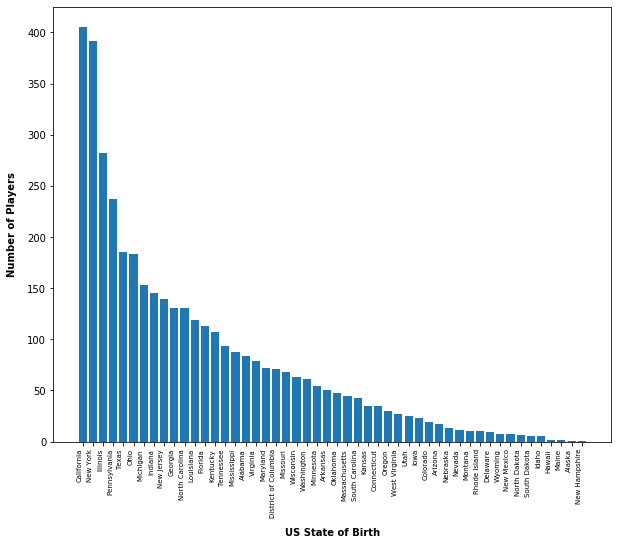

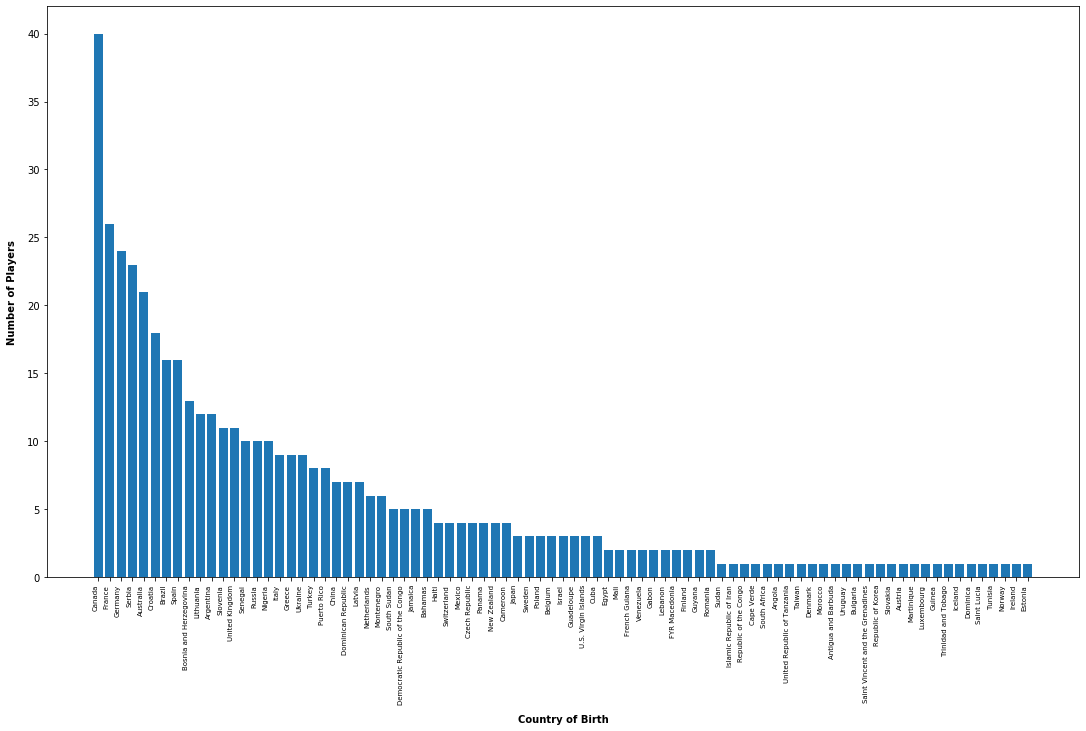

In [6]:
def geographyPlot():
    stateList = []; countryList = []
    for player in playersHash.keys():
        stateList.append(playersHash[player]['meta_info'].birthState)
        countryList.append(playersHash[player]['meta_info'].birthCountry)
    #stateList contains all players born in the US
    stateList = filter(lambda x: x != '', stateList)
    stateHash = dict(Counter(stateList))
    stateHash = OrderedDict(sorted(stateHash.items(), reverse=True, key=lambda t: t[1]))
    print(stateHash)
    #countryList contains all players born in ex-US
    countryList = filter(lambda x: x != 'United States of America', countryList)
    countryList = filter(lambda x: x != '', countryList)
    countryHash = dict(Counter(countryList))
    countryHash = OrderedDict(sorted(countryHash.items(), reverse=True, key=lambda t: t[1]))


    #Plot Birth State of US-Born Players (2)
    f, ax = plt.subplots(1)
    stateList = stateHash.keys(); stateVals = stateHash.values()
    ax.bar(np.arange(len(stateList)), stateVals)
    ax.set_xticks(np.arange(len(stateList)))
    ax.set_xticklabels(stateList, rotation=90, ha='right', fontsize=7)
    ax.set_xlabel('US State of Birth', fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Players', fontweight='bold', labelpad=10)
    plt.show();

    #Plot Birth Countries of non-US-Born Players (3)
    f, ax = plt.subplots(1)
    countryList = countryHash.keys(); countryVals = countryHash.values()
    ax.bar(np.arange(len(countryList)), countryVals)
    ax.set_xticks(np.arange(len(countryList)))
    ax.set_xticklabels(countryList, rotation=90, ha='right', fontsize=7)
    ax.set_xlabel('Country of Birth', fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Players', fontweight='bold', labelpad=10)
    
    f.set_size_inches(18.5, 10.5, forward=True)
    plt.show()
    
geographyPlot()

***
## Creating Databases
Pandas databases are a powerful tool to query large amounts of data, as we will be doing here. For that reason, we are going to insert all of the data scraped above into a Pandas database. The below code will take player overview data from playerHash and insert it into player_df<br>
>For documentation on pandas: https://pypi.org/project/pandas/

***
## Scraping All Players Table Statistics (perGame, total, per36, etc)

### perGameScraper

## Table Generation

Just like with playerTable, we're going to generate SQLite tables for all of the other tables we've scraped, in order to quickly access information and generate immediate queries.

## Example Queries (Simple)

The following are example queries we can make across all of the generated tables. As can be seen below, the structure of each SQLite table allows for immense flexibility and speed gains as compared to looking at the website itself. We will utilize this structure for more specific trend-, team-, and era- related investigations.